In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

%matplotlib widget

## Memeriksa ketersedian CUDA
CUDA memanfaatkan komputasi pemrogramam paralel dengan menggunakan GPU

In [15]:
if torch.cuda.is_available():
    dev = 'cuda'
else:
    dev = 'cpu'

device = torch.device(dev)
print(f'Komputasi menggunakan {dev}...') 

Komputasi menggunakan cuda...


## Memuat Data
Memuat data, kemudian dibagi menjadi 3 bagian training set, validation set, test set.

In [16]:
# Memuat data Iris.csv
def get_data(path):
    path = '../machinel/data/Iris.csv'

    df = pd.read_csv(path)
    X = df.iloc[:,1:5].values
    X = torch.tensor(X, dtype=torch.float32)

    y = df.Species
    enc = LabelEncoder()
    y = enc.fit_transform(y)
    y = torch.from_numpy(y).type(torch.LongTensor)
    return X, y

# Membagi dataset menjadi 3 bagian: training, validation, dan test set.

def split_data(X, y, b_size):
    training, test_x, training_label, test_y = train_test_split(X,y, test_size=0.2, random_state=42)
    train_x, val_x, train_y, val_y = train_test_split(training, training_label, test_size=0.2, random_state=42)

    train = TensorDataset(train_x, train_y)
    val = TensorDataset(val_x, val_y)
    test = TensorDataset(test_x, test_y)

    train_loader = DataLoader(train, batch_size=b_size)
    val_loader = DataLoader(val, batch_size=b_size)
    test_loader = DataLoader(test, batch_size=b_size)

    print(f'train size: {len(train_loader.dataset)}, val size: {len(val_loader.dataset)}, test size: {len(test_loader.dataset)}')
    print(f'train num bacthes: {len(train_loader)}, val : {len(val_loader)}, test : {len(test_loader)}')
    return train_loader, val_loader, test_loader

## Membangun arsitektur model LSTM

In [17]:
class Lstmiris(nn.Module):
    def __init__(self,input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()

        #hidden dim
        self.hidden_dim = hidden_dim

        #number of hidden layers
        self.layer_dim = layer_dim

        #LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, dropout=0.2, batch_first=True).to(device)

        #readout layer
        self.fc = nn.Linear(hidden_dim, output_dim).to(device)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        # time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :])
        out = self.dropout(out)
        # out.size() --> 100, 10
        #print(out.size())
        return out

## Menampilkan Confusion Matrix

In [18]:
def cm_display(pred, target):
    cm = confusion_matrix(pred, target)
    label_dict = ['setosa', 'versicolor', 'virginica']
    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay(cm, display_labels=[label_dict[i] for i in range(3)]).plot(ax=ax, cmap='Blues')
    plt.show()

## Tahap Training

In [19]:
#train the model
def train_model(dataloader, model, loss_fn, optimizer, batch_size):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    model.train()
    for count, (X, y) in enumerate(dataloader):
        #activate cuda, reshape
        X = X.to(device)
        X = X.view(-1,1,4)
        y = y.to(device)

        #forward propagation, compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        #Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss +=loss
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if (count+1) % 5 == 0:
            loss, current = loss.item(), count * batch_size + len(X)
            print(f'loss: {loss} [{current}/{size}]')
            
    train_loss /= num_batches
    correct /= size
    print(f'Train: Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss}')

## Tahap Validasi dan Uji

In [20]:
def test_model(dataloader, model, loss_fn, mode='val'):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    pred_cm, lab_cm = [], []
    
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            X = X.view(-1,1,4)
            y = y.to(device)
            
            pred = model(X)
            loss = loss_fn(pred, y)
            test_loss += loss.item()
            tem_cor = pred.argmax(1)
            correct += (tem_cor == y).type(torch.float).sum().item()
            if mode=='test':
                pred_cm.append(tem_cor.cpu().detach().numpy()) #yhat.detach().numpy()
                lab_cm.append(y.cpu().detach().numpy())
    
    if mode=='test':
        pred_cm = np.array(pred_cm)
        lab_cm = np.array(lab_cm)
        #pred_cm = pred_cm
        #lab_cm = lab_cm
        cm_display(pred_cm.flatten(), lab_cm.flatten())

    test_loss /= num_batches
    correct /= size
    print(f'Test: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss}, Data Size: {size}')

    return test_loss, correct

## Menetapkan hyperparameter

In [21]:
#define the hyperparameter
learning_rate = 1e-4
epochs = 250
input_dim = 4
hidden_dim = 128
layer_dim = 3
output_dim = 3

model = Lstmiris(input_dim, hidden_dim, layer_dim, output_dim) #(self,input_dim, hidden_dim, layer_dim, output_dim):
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)

## Main Program

In [22]:
# memuat data
path = '../machinel/data/Iris.csv'
X, y = get_data(path)


#split data
batch_size = 5
train, val, test = split_data(X, y, batch_size)
# memulai training
test_loss_hist, test_acc_hist, epoch_list = [],[],[]
best_model = 0

for t in range(epochs):
    print(f'Epoch {t+1}\n------------------------------')
    train_model(train, model, loss_fn, optimizer, batch_size)
    loss, accuracy = test_model(val, model, loss_fn)
    if accuracy>best_model:
        best_model=accuracy
        print('Saving the model...')
        torch.save(model.state_dict(), 'iris_model_lstm')
    test_loss_hist.append(loss)
    test_acc_hist.append(accuracy)
    epoch_list.append(t)

print('done!')

#done

train size: 96, val size: 24, test size: 30
train num bacthes: 20, val : 5, test : 6
Epoch 1
------------------------------
loss: 1.1125777959823608 [25/96]
loss: 1.0950040817260742 [50/96]
loss: 1.1452388763427734 [75/96]
loss: 1.0329447984695435 [96/96]
Train: Accuracy: 33.3%, Avg loss: 1.0971813201904297
Test: Accuracy: 33.3%, Avg loss: 1.098099660873413, Data Size: 24
Saving the model...
Epoch 2
------------------------------
loss: 1.1160104274749756 [25/96]
loss: 1.0815075635910034 [50/96]
loss: 1.1264078617095947 [75/96]
loss: 1.03350031375885 [96/96]
Train: Accuracy: 33.3%, Avg loss: 1.0952141284942627
Test: Accuracy: 33.3%, Avg loss: 1.0980682373046875, Data Size: 24
Epoch 3
------------------------------
loss: 1.107224464416504 [25/96]
loss: 1.0729916095733643 [50/96]
loss: 1.1149394512176514 [75/96]
loss: 1.059057593345642 [96/96]
Train: Accuracy: 33.3%, Avg loss: 1.094100832939148
Test: Accuracy: 33.3%, Avg loss: 1.0980023860931396, Data Size: 24
Epoch 4
--------------------

## Menampilkan plot untuk accuracy & loss dari model

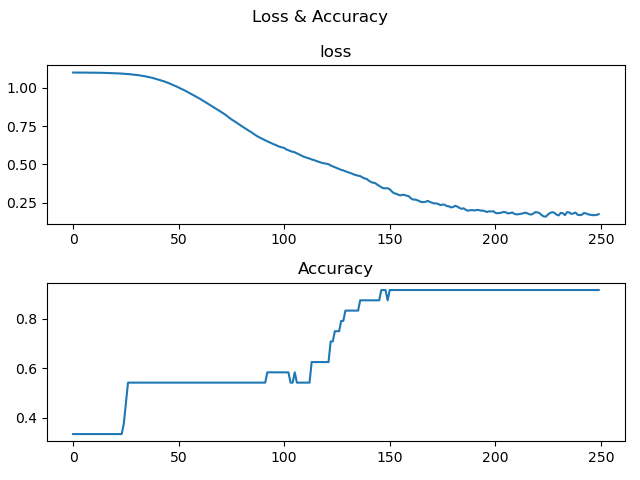

In [23]:
fig, ax = plt.subplots(2)
fig.suptitle('Loss & Accuracy')
ax[0].plot(epoch_list, test_loss_hist)
ax[0].set_title('loss')
ax[1].plot(epoch_list, test_acc_hist)
ax[1].set_title('Accuracy')
fig.tight_layout()
plt.show()

## Melakukan pengujian dengan test set

Lstmiris(
  (lstm): LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


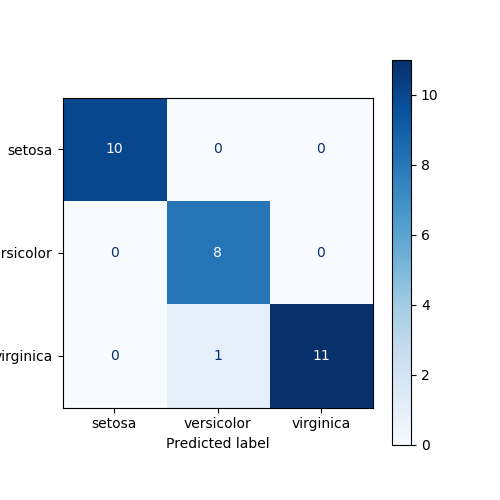

Test: Accuracy: 96.7%, Avg loss: 0.2590997690955798, Data Size: 30
done!


In [25]:
model.load_state_dict(torch.load('iris_model_lstm'))
print(model.eval())

loss, accuracy = test_model(test, model, loss_fn, mode='test')
#display confusion matrix
print('done!')
